# imports

In [2]:
!pip install -q scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import json
import re
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [4]:
project_path = '/content/drive/MyDrive/Colab Notebooks/PatternMining'

# Frequent Pattern Extraction

## Load dataset

In [521]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

In [522]:
data.drop(columns=['release date', 'last_update', 'img', 'title', 'Processed_title', 'Stemmed_title', 'Lemmatized_title', 'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres', 'score'], inplace=True)

## Distribute Numerical values

In [523]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for column in numeric_columns:
    data[column] = pd.cut(data[column], bins=3, labels=['low', 'medium', 'high'])

print(data.head())

                  genres                product rating user score  \
0        Auto Racing Sim          Rated E For Everyone       high   
1        Auto Racing Sim          Rated E For Everyone       high   
2            Western RPG              Rated T For Teen       high   
3  Vertical Shoot-'Em-Up  Rated E +10 For Everyone +10     medium   
4                    FPS              Rated T For Teen     medium   

  user ratings count platform metascore metascore_count  \
0                low       XB        59             low   
1                low       GC        56             low   
2                low       PC        63             low   
3                low       NS        61             low   
4                low       PC        70             low   

                 publisher            developer total_sales na_sales  \
0  Gathering of Developers     Terminal Reality         low   medium   
1                 VU Games     Terminal Reality         low      low   
2             

## Encoding

In [524]:
data_one_hot = pd.get_dummies(data)
print(data_one_hot.head())

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  genres_3D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_4X Strategy  genres_Action  genres_Action Adventure  \
0               False          False                    False   
1               False       

## Choose min-support & min-confidence

In [525]:
methods_data = {
    1: {"support": 0.005, "confidence": 0.50},
    2: {"support": 0.005, "confidence": 0.70},
    3: {"support": 0.01, "confidence": 0.60},
    4: {"support": 0.01, "confidence": 0.80},
    5: {"support": 0.02, "confidence": 0.70},
    6: {"support": 0.02, "confidence": 0.90},
    7: {"support": 0.05, "confidence": 0.80},
    8: {"support": 0.05, "confidence": 0.90},
    9: {"support": 0.08, "confidence": 0.80},
    10: {"support": 0.10, "confidence": 0.90},
    11: {"support": 0.20, "confidence": 0.90},
    12: {"support": 0.30, "confidence": 0.90},
    13: {"support": 0.50, "confidence": 0.90},
    14: {"support": 0.70, "confidence": 0.90},
    15: {"support": 0.80, "confidence": 0.90},
    16: {"support": 0.90, "confidence": 0.90},
}

method_number = 16

method = method_data = methods_data[method_number]

min_support_threshold = method['support']
min_confidence_threshold = method['confidence']


## Frequent item-sets

In [526]:
frequent_itemsets = apriori(data_one_hot, min_support=min_support_threshold, use_colnames=True)
print(frequent_itemsets)

    support                                           itemsets
0  0.999907                           (user ratings count_low)
1  0.932099                              (metascore_count_low)
2  0.999907                                  (total score_low)
3  0.932099      (metascore_count_low, user ratings count_low)
4  0.999907          (user ratings count_low, total score_low)
5  0.932099             (metascore_count_low, total score_low)
6  0.932099  (metascore_count_low, user ratings count_low, ...


## Association Rules

In [527]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence_threshold)
print(rules)

                                      antecedents  \
0                           (metascore_count_low)   
1                        (user ratings count_low)   
2                        (user ratings count_low)   
3                               (total score_low)   
4                           (metascore_count_low)   
5                               (total score_low)   
6   (metascore_count_low, user ratings count_low)   
7          (metascore_count_low, total score_low)   
8       (user ratings count_low, total score_low)   
9                           (metascore_count_low)   
10                       (user ratings count_low)   
11                              (total score_low)   

                                      consequents  antecedent support  \
0                        (user ratings count_low)            0.932099   
1                           (metascore_count_low)            0.999907   
2                               (total score_low)            0.999907   
3                 

## avg metrics

In [528]:
average_metrics = {}
for metric in ['lift', 'leverage', 'conviction', 'zhangs_metric']:
    average_metrics[metric] = rules[metric].replace([np.inf, -np.inf], np.nan).mean()

average_metrics = pd.Series(average_metrics)

print("\nAverage Metrics excluding inf values):")
print(average_metrics)


Average Metrics excluding inf values):
lift             1.000093
leverage         0.000088
conviction       1.001279
zhangs_metric    0.583904
dtype: float64


## Top N rules

In [529]:
n = 10
scaler = MinMaxScaler()
metrics = ['lift', 'leverage', 'conviction', 'zhangs_metric']
rules.replace([np.inf, -np.inf], np.nan, inplace=True)
rules[metrics] = scaler.fit_transform(rules[metrics])

# Compute a composite score (weighted sum of normalized metrics)
rules['composite_score'] = (rules['lift'] +
                            rules['leverage'] +
                            rules['conviction'] +
                            rules['zhangs_metric']) / len(metrics)

# Rank the rules based on the composite score
ranked_rules = rules.sort_values(by='composite_score', ascending=False)

# Select the top n rules
top_rules = ranked_rules.head(n)

## Save Best Rules

In [530]:
output_file = f'{project_path}/best rules/method{method_number}.txt'
with open(output_file, 'w') as f:
    for index, row in top_rules.iterrows():
        antecedents = list(row['antecedents'])
        consequents = list(row['consequents'])
        support = row['support']
        confidence = row['confidence']
        lift = row['lift']
        leverage = row['leverage']
        conviction = row['conviction']
        zhangs_metric = row['zhangs_metric']

        f.write(f"Rule #{index + 1}:\n")
        f.write(f"Antecedents: {antecedents}\n")
        f.write(f"Consequents: {consequents}\n")
        f.write(f"Support: {support:.4f}\n")
        f.write(f"Confidence: {confidence:.4f}\n")
        f.write(f"Lift: {lift:.4f}\n")
        f.write(f"Leverage: {leverage:.4f}\n")
        f.write(f"Conviction: {conviction:.4f}\n")
        f.write(f"Zhang's Metric: {zhangs_metric:.4f}\n")
        f.write("-------------------------\n")

print(f"Output saved to {output_file}")

Output saved to /content/drive/MyDrive/Colab Notebooks/PatternMining/best rules/method16.txt


# Clustering

## Load dataset

In [5]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

In [6]:
# ['title', 'genres', 'product rating', 'user score', 'user ratings count',
#        'platform', 'metascore', 'metascore_count', 'img', 'publisher',
#        'developer', 'total_sales', 'na_sales', 'pal_sales', 'other_sales',
#        'release date', 'last_update', 'total score', 'score',
#        'Processed_title', 'Stemmed_title', 'Lemmatized_title',
#        'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres']

data.drop(columns=['title', 'user ratings count',
        'metascore_count', 'img',
       'developer','release date', 'last_update', 'total score', 'score',
       'Processed_title', 'Stemmed_title', 'Lemmatized_title',
       'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres'], inplace=True)

## Numerical & Categorical Separation

In [7]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['user score', 'total_sales', 'na_sales', 'pal_sales', 'other_sales']
Categorical columns: ['genres', 'product rating', 'platform', 'metascore', 'publisher']


## Encode Categorical Cols

In [8]:
# One-hot encode categorical columns
data_encoded = pd.get_dummies(data, columns=categorical_columns)

# Display the first few rows of the encoded DataFrame
print(data_encoded.head())


   user score  total_sales  na_sales  pal_sales  other_sales  \
0      6.9606       0.1181    0.0886     0.0246       0.0049   
1      6.9606       0.0689    0.0541     0.0148       0.0000   
2      7.5000       0.2563    0.1518     0.0930       0.0115   
3      6.2000       0.2563    0.1518     0.0930       0.0115   
4      6.6000       0.2563    0.1518     0.0930       0.0115   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Scale Numerical Cols

In [9]:
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(data[numerical_columns])
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_columns)

processed_data = pd.concat([scaled_numerical_df, data_encoded.drop(columns=numerical_columns)], axis=1)

print(processed_data.head())

   user score  total_sales  na_sales  pal_sales  other_sales  \
0    0.023124    -0.950788 -0.624495  -1.285392    -1.239778   
1    0.023124    -1.507935 -1.277619  -1.559966    -2.433346   
2    0.429625     0.614208  0.571952   0.631018     0.367886   
3   -0.550078     0.614208  0.571952   0.631018     0.367886   
4   -0.248631     0.614208  0.571952   0.631018     0.367886   

   genres_2D Beat-'Em-Up  genres_2D Fighting  genres_2D Platformer  \
0                  False               False                 False   
1                  False               False                 False   
2                  False               False                 False   
3                  False               False                 False   
4                  False               False                 False   

   genres_3D Beat-'Em-Up  genres_3D Fighting  ...  publisher_evoline srl  \
0                  False               False  ...                  False   
1                  False               Fal

## Kmeans

In [10]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(processed_data)

data['Cluster'] = clusters

print(data.head())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


                  genres                product rating  user score platform  \
0        Auto Racing Sim          Rated E For Everyone      6.9606       XB   
1        Auto Racing Sim          Rated E For Everyone      6.9606       GC   
2            Western RPG              Rated T For Teen      7.5000       PC   
3  Vertical Shoot-'Em-Up  Rated E +10 For Everyone +10      6.2000       NS   
4                    FPS              Rated T For Teen      6.6000       PC   

  metascore                publisher  total_sales  na_sales  pal_sales  \
0        59  Gathering of Developers       0.1181    0.0886     0.0246   
1        56                 VU Games       0.0689    0.0541     0.0148   
2        63                    Aspyr       0.2563    0.1518     0.0930   
3        61               10tons Ltd       0.2563    0.1518     0.0930   
4        70      Cadenza Interactive       0.2563    0.1518     0.0930   

   other_sales  Cluster  
0       0.0049        2  
1       0.0000        2  
2 

### TSNE visualization

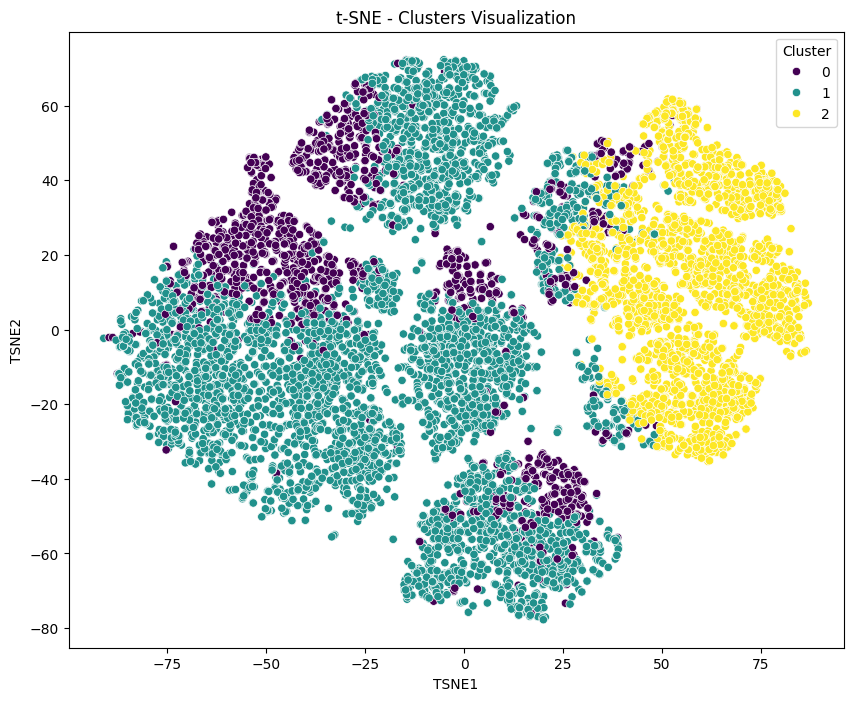

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(processed_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE - Clusters Visualization')
plt.show()


### PCA visualization

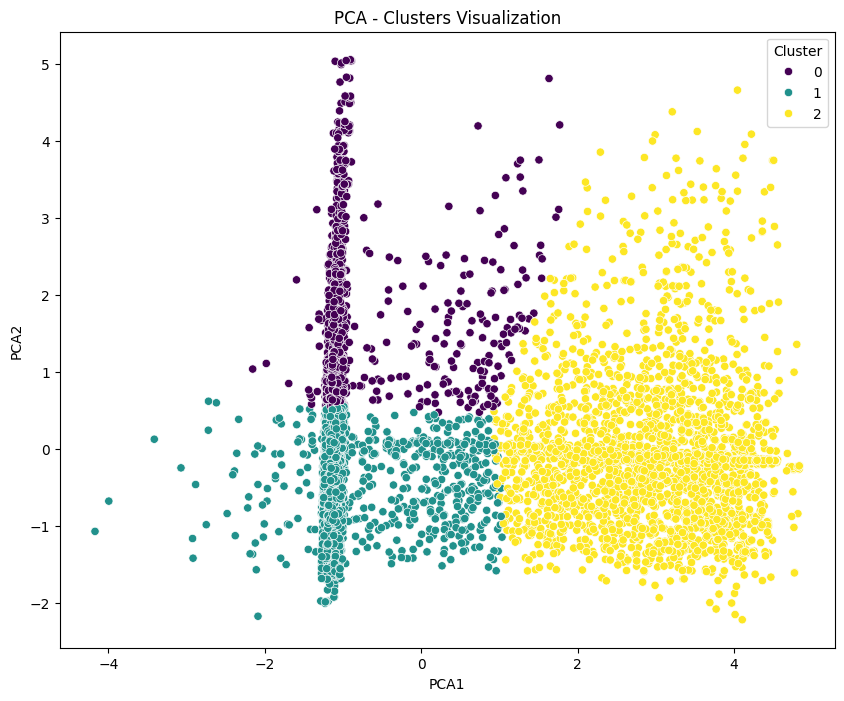

In [11]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()


### Descriptive statistics

In [13]:
cluster_descriptive_stats = data.groupby('Cluster').describe()
print(cluster_descriptive_stats)

        user score                                                     \
             count      mean       std  min     25%     50%  75%  max   
Cluster                                                                 
0           1787.0  4.964466  1.207608  0.3  4.5000  5.3000  5.9  6.4   
1           6235.0  7.515124  0.698307  6.2  6.9606  7.5000  8.0  9.8   
2           2729.0  6.879895  1.246707  0.5  6.5000  6.9606  7.6  9.7   

        total_sales            ... pal_sales         other_sales            \
              count      mean  ...       75%     max       count      mean   
Cluster                        ...                                           
0            1787.0  0.246817  ...    0.0930  0.1722      1787.0  0.011856   
1            6235.0  0.251734  ...    0.0930  0.1821      6235.0  0.011707   
2            2729.0  0.059265  ...    0.0197  0.1378      2729.0  0.004845   

                                                           
              std     min     25

### Feature Distribution

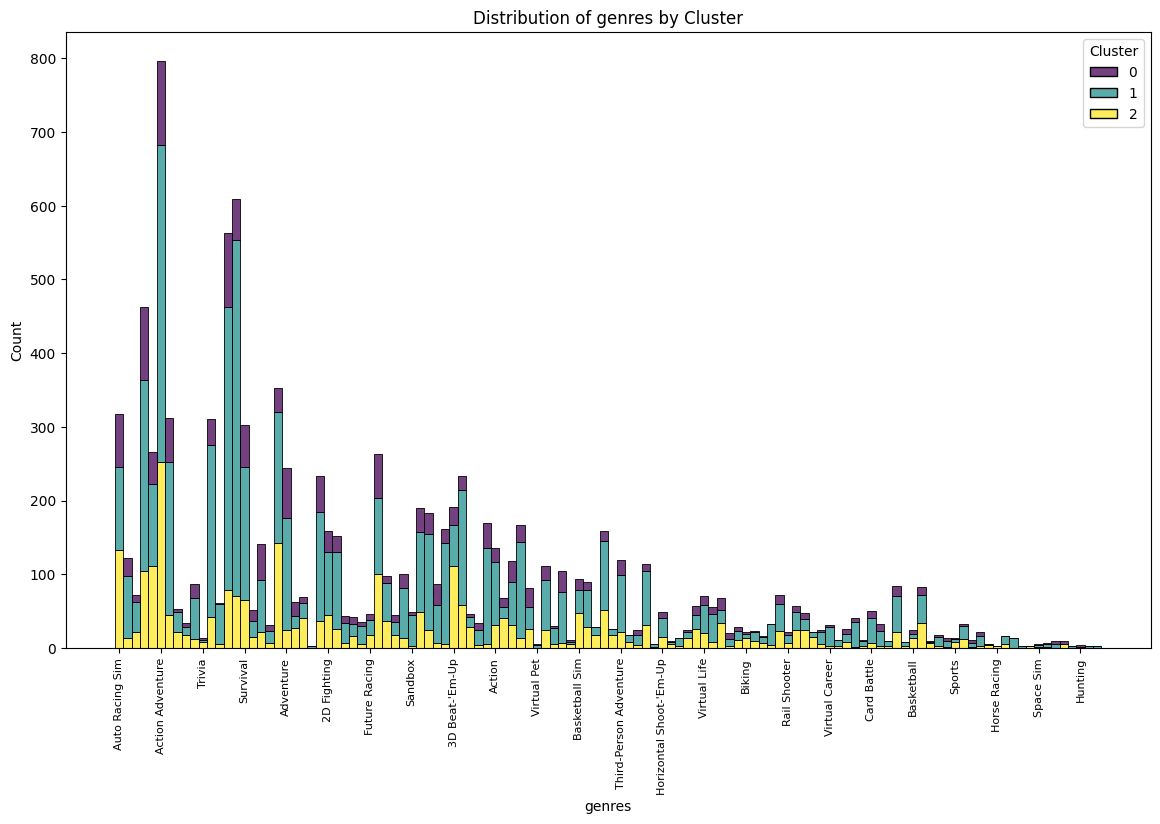

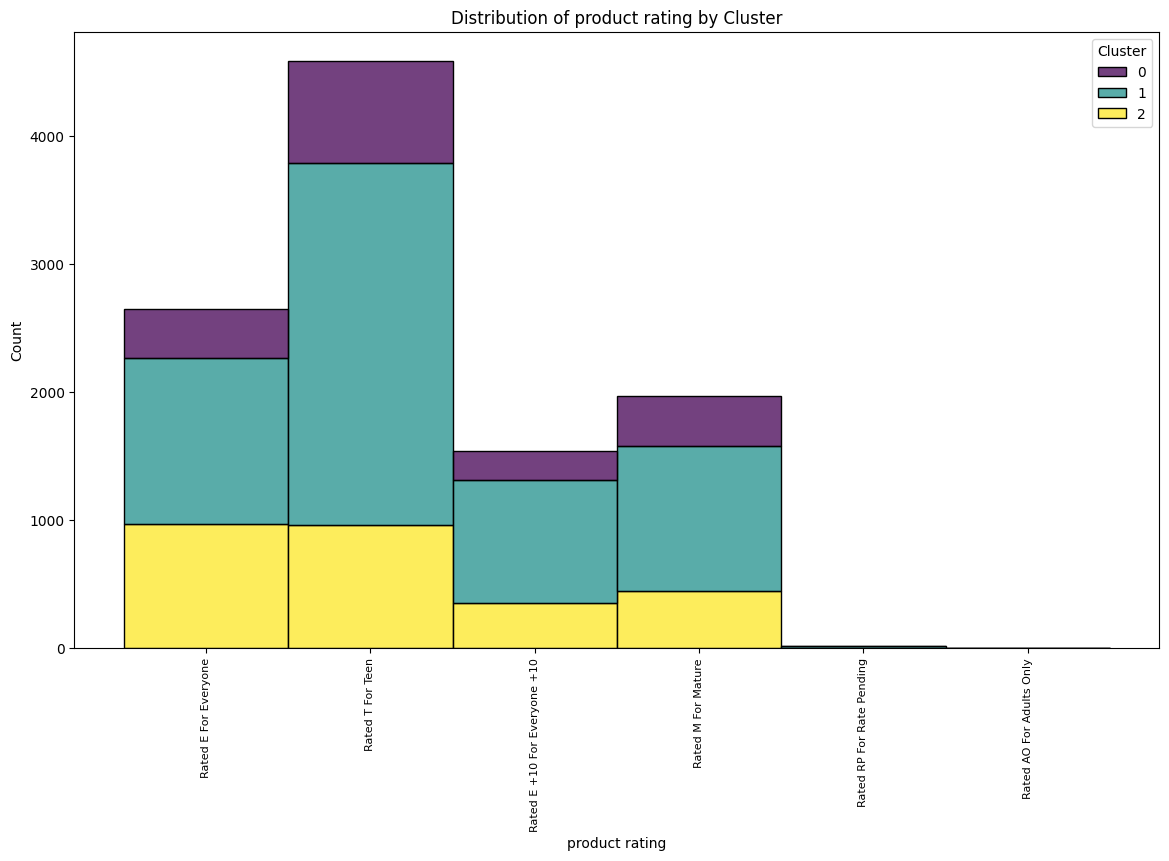

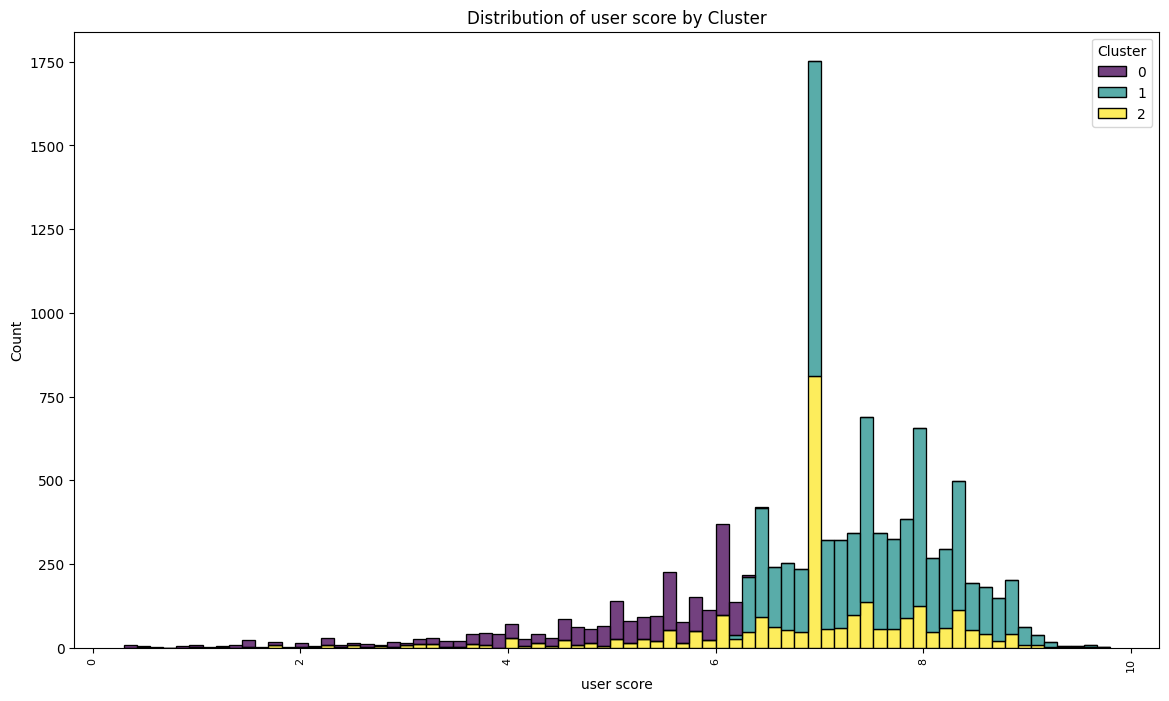

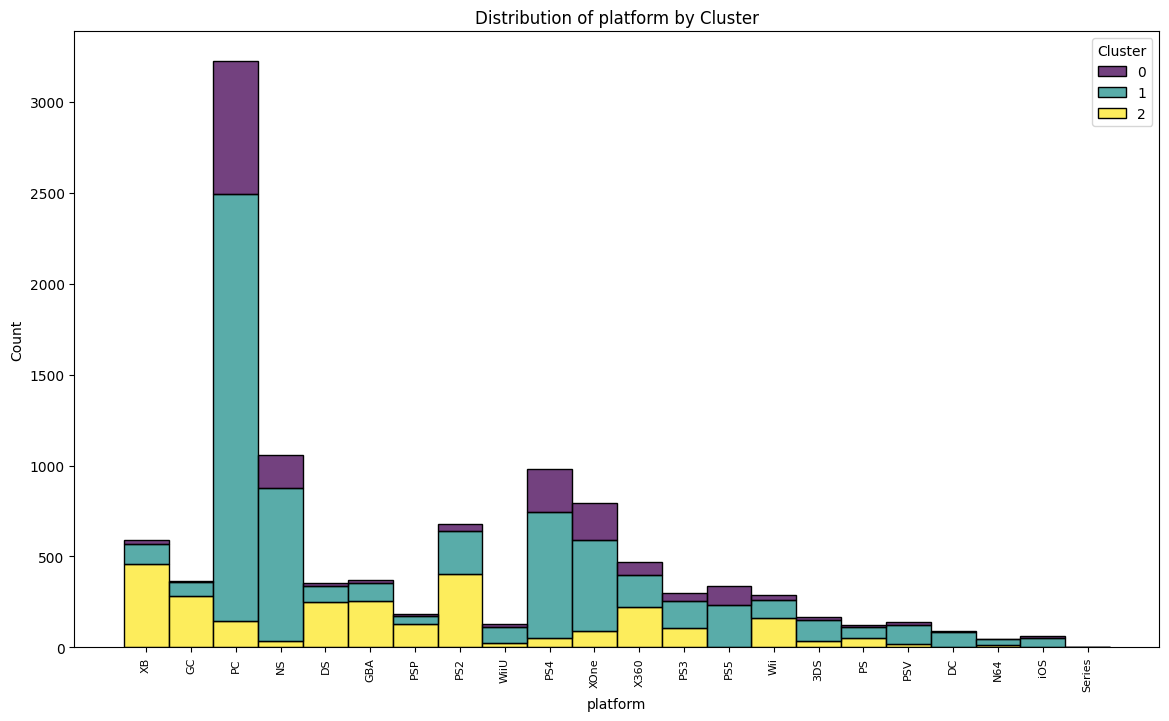

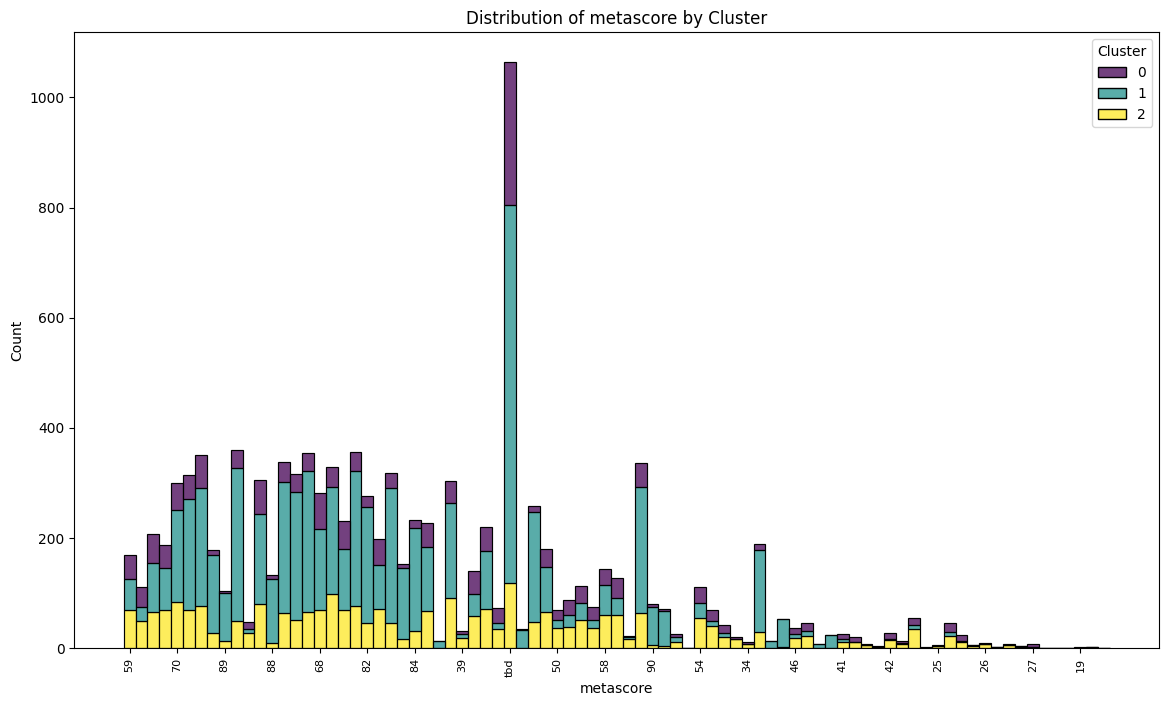

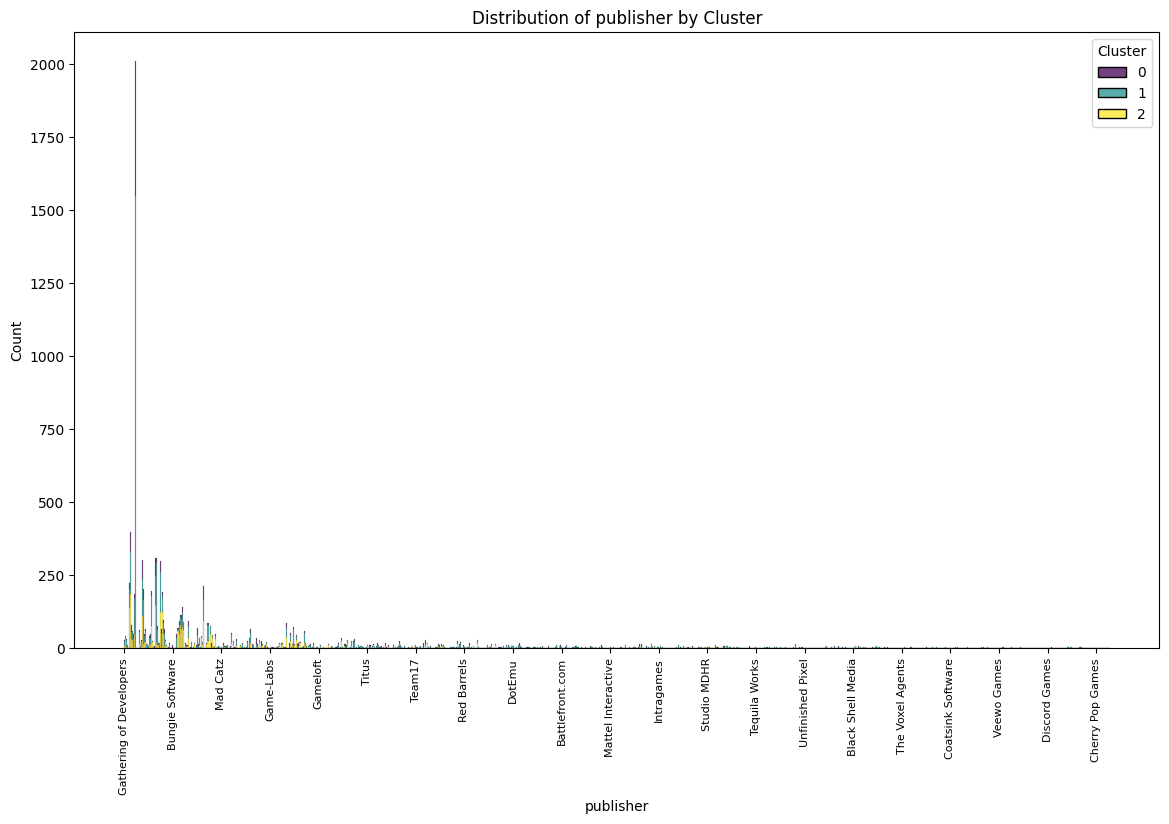

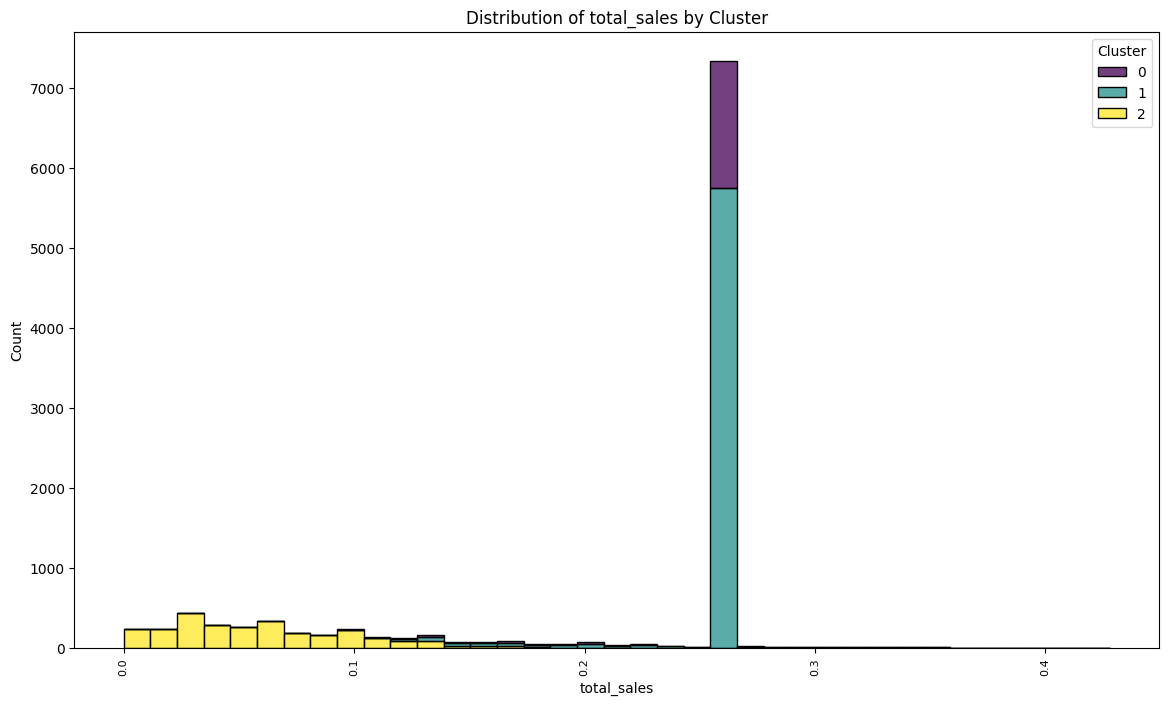

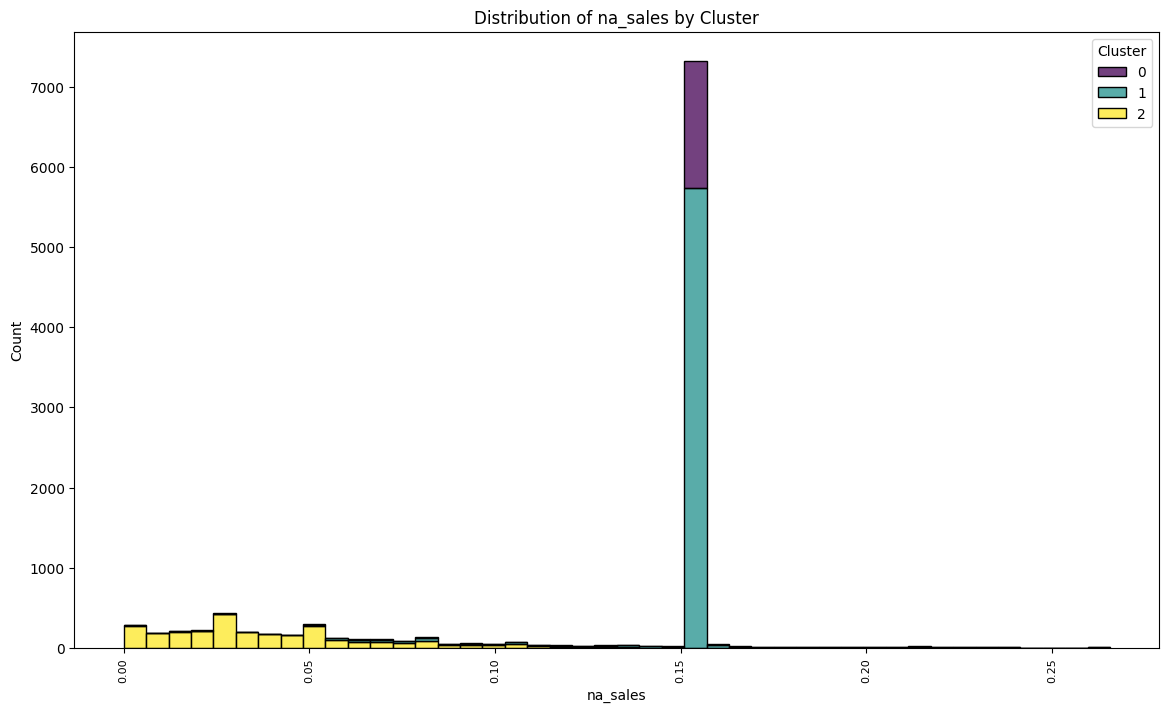

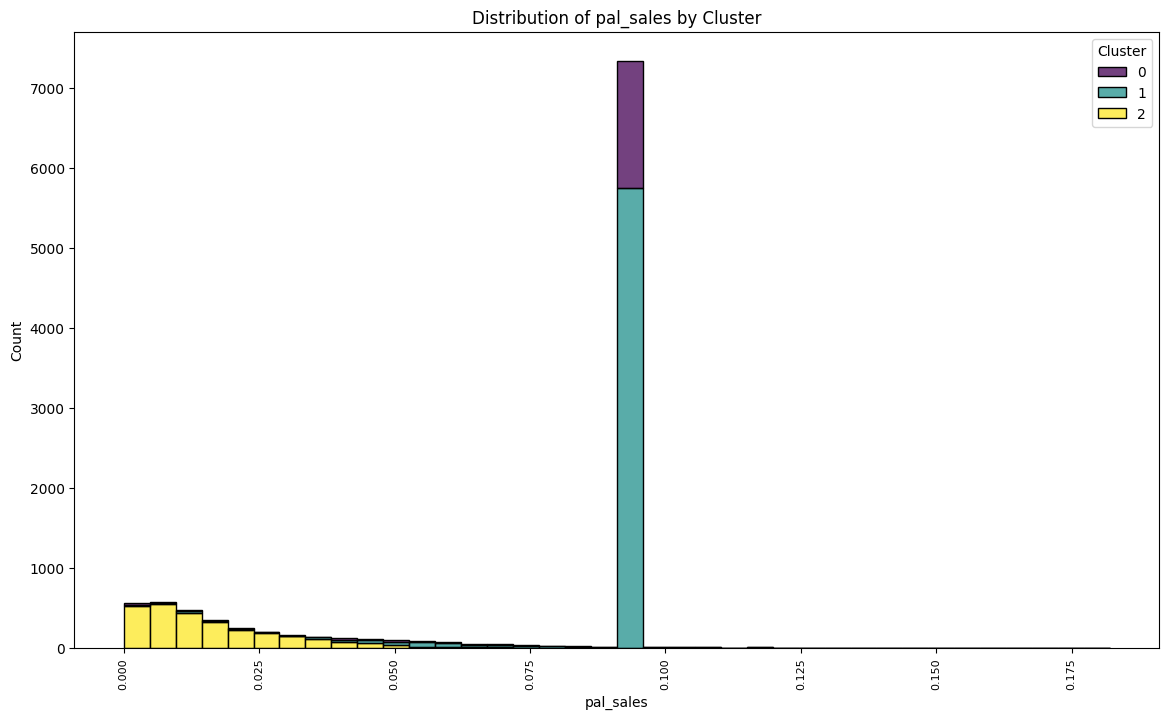

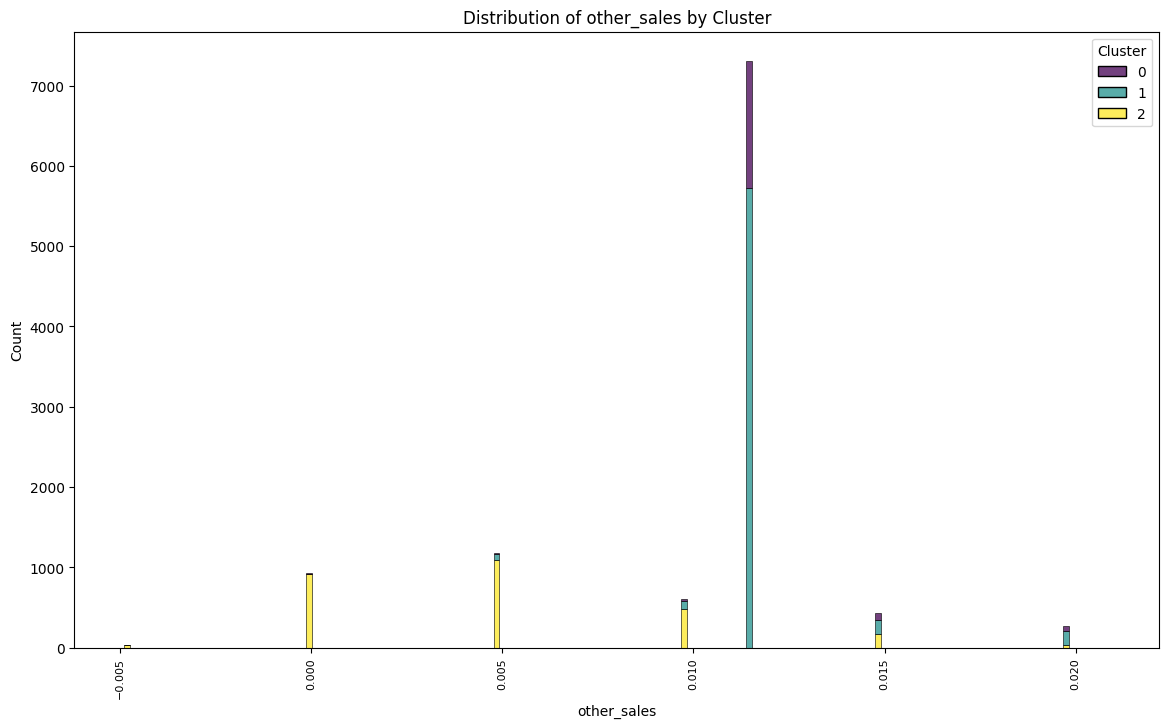

In [16]:
# Set a larger figure size for all plots
plt.rcParams['figure.figsize'] = [14, 8]

for column in data.columns:
    if column != 'Cluster':
        plt.figure()
        sns.histplot(data=data, x=column, hue='Cluster', multiple='stack', palette='viridis')
        plt.title(f'Distribution of {column} by Cluster')

        # Get current x-axis labels
        labels = plt.gca().get_xticklabels()

        # Threshold for maximum number of labels before reducing
        max_labels = 20

        if len(labels) > max_labels:
            # Determine the step size to display every nth label
            step = max(1, len(labels) // max_labels)  # Show at most max_labels

            # Apply rotation and limit the number of labels
            plt.xticks(ticks=range(0, len(labels), step), rotation=90, fontsize=8)
        else:
            plt.xticks(rotation=90, fontsize=8)

        plt.show()

### Feature-Feature plt

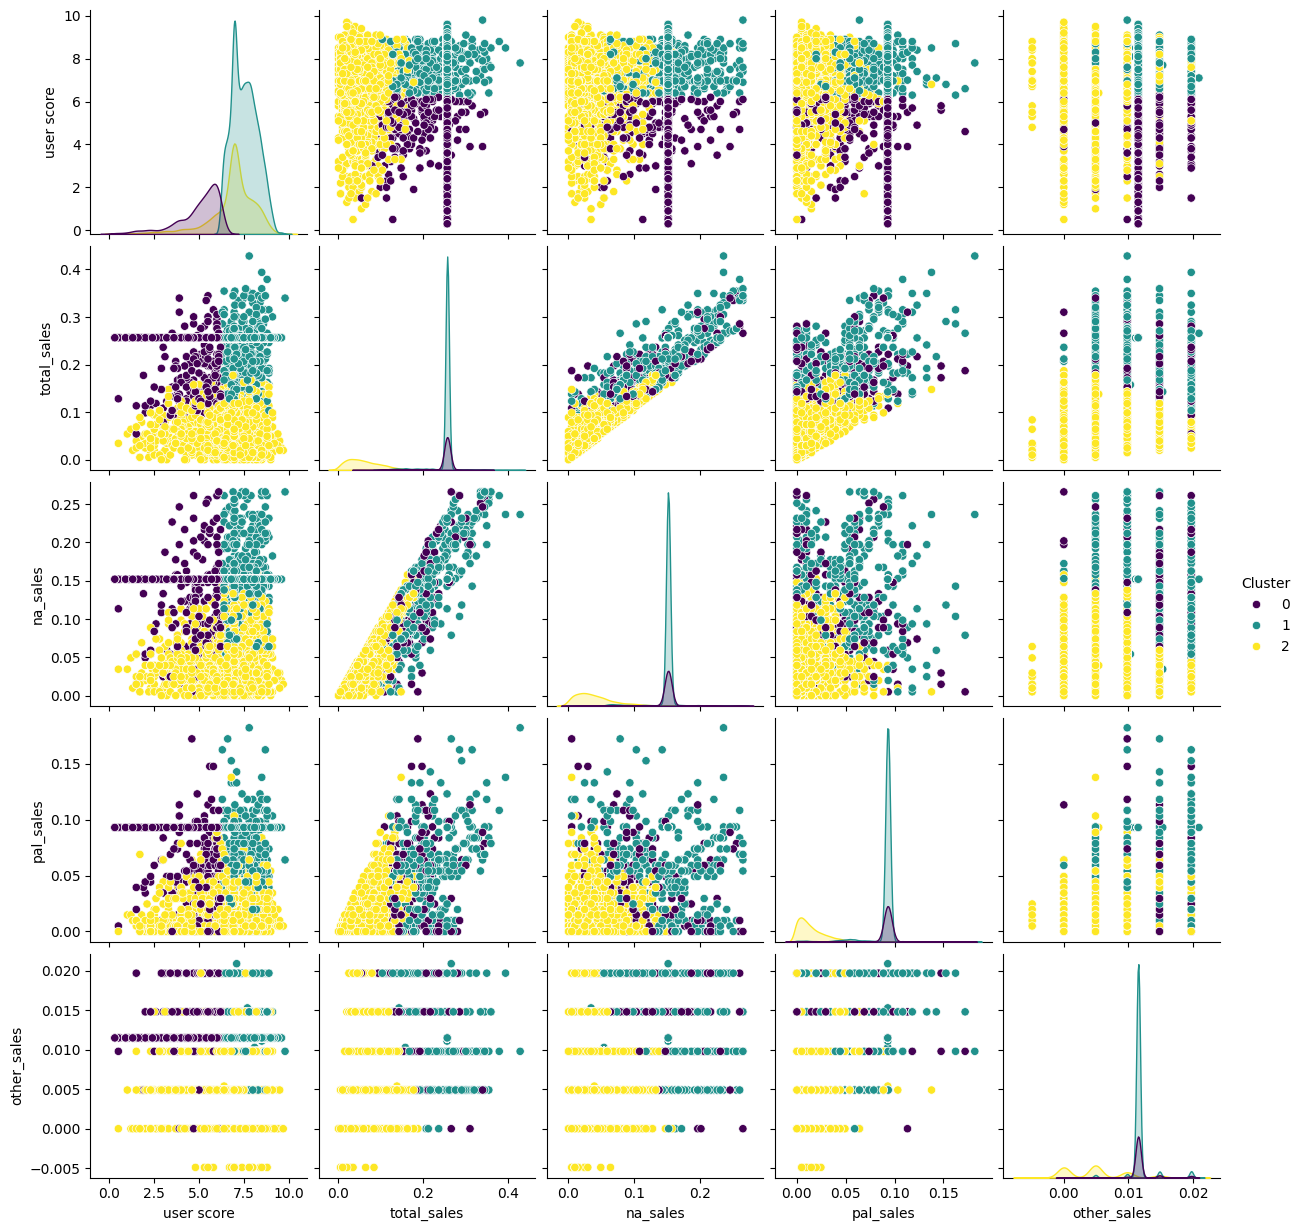

In [15]:
# Use pair plots to visualize relationships between features within each cluster
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


## Kmedian

In [18]:
optimal_k = 3

kmedoids = KMedoids(n_clusters=optimal_k, random_state=42)
clusters = kmedoids.fit_predict(processed_data)

data['Cluster'] = clusters

print(data.head())

                  genres                product rating  user score platform  \
0        Auto Racing Sim          Rated E For Everyone      6.9606       XB   
1        Auto Racing Sim          Rated E For Everyone      6.9606       GC   
2            Western RPG              Rated T For Teen      7.5000       PC   
3  Vertical Shoot-'Em-Up  Rated E +10 For Everyone +10      6.2000       NS   
4                    FPS              Rated T For Teen      6.6000       PC   

  metascore                publisher  total_sales  na_sales  pal_sales  \
0        59  Gathering of Developers       0.1181    0.0886     0.0246   
1        56                 VU Games       0.0689    0.0541     0.0148   
2        63                    Aspyr       0.2563    0.1518     0.0930   
3        61               10tons Ltd       0.2563    0.1518     0.0930   
4        70      Cadenza Interactive       0.2563    0.1518     0.0930   

   other_sales  Cluster  
0       0.0049        0  
1       0.0000        0  
2 

### TSNE visualization

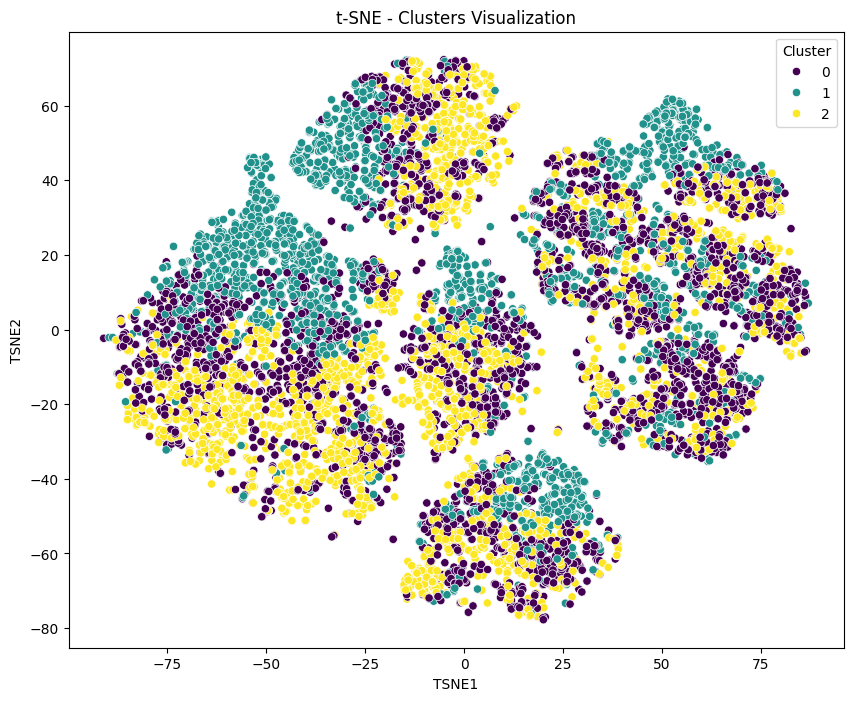

In [20]:
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(processed_data)
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Cluster', palette='viridis')
plt.title('t-SNE - Clusters Visualization')
plt.show()

### PCA visualization

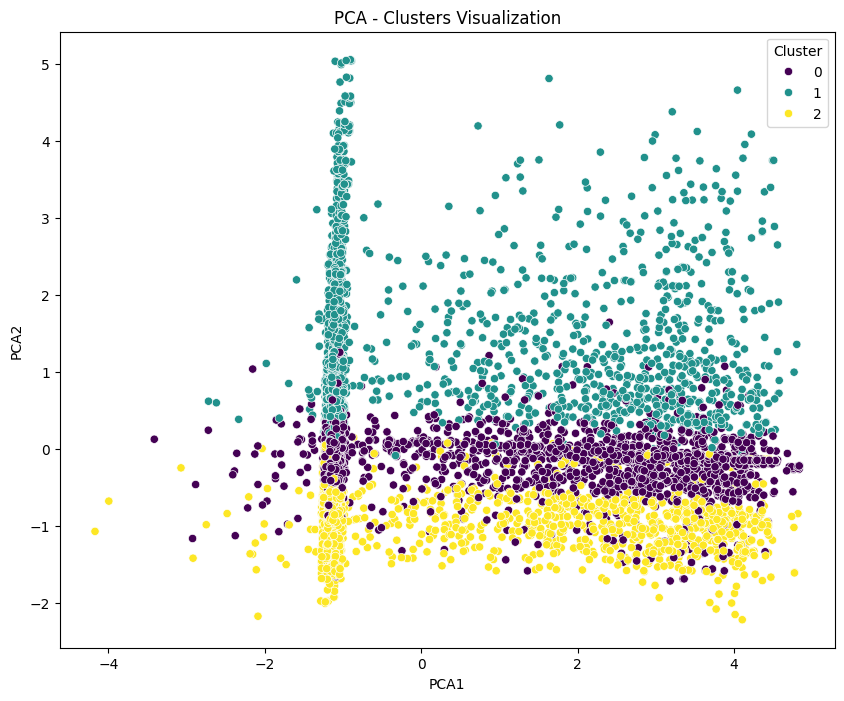

In [19]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(processed_data)
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Visualize the PCA-reduced data
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='viridis')
plt.title('PCA - Clusters Visualization')
plt.show()


### Descriptive statistics

In [21]:
cluster_descriptive_stats = data.groupby('Cluster').describe()
print(cluster_descriptive_stats)


        user score                                                  \
             count      mean       std  min     25%  50%  75%  max   
Cluster                                                              
0           4444.0  7.110209  0.456321  4.6  6.9606  7.0  7.4  9.1   
1           2850.0  5.257965  1.252245  0.3  4.7000  5.6  6.2  6.9   
2           3457.0  8.076529  0.504809  6.9  7.8000  8.1  8.4  9.8   

        total_sales            ... pal_sales         other_sales            \
              count      mean  ...       75%     max       count      mean   
Cluster                        ...                                           
0            4444.0  0.186967  ...     0.093  0.1722      4444.0  0.009465   
1            2850.0  0.207731  ...     0.093  0.1722      2850.0  0.010349   
2            3457.0  0.216791  ...     0.093  0.1821      3457.0  0.010368   

                                                           
              std     min     25%     50%     75% 

### Feature Distribution

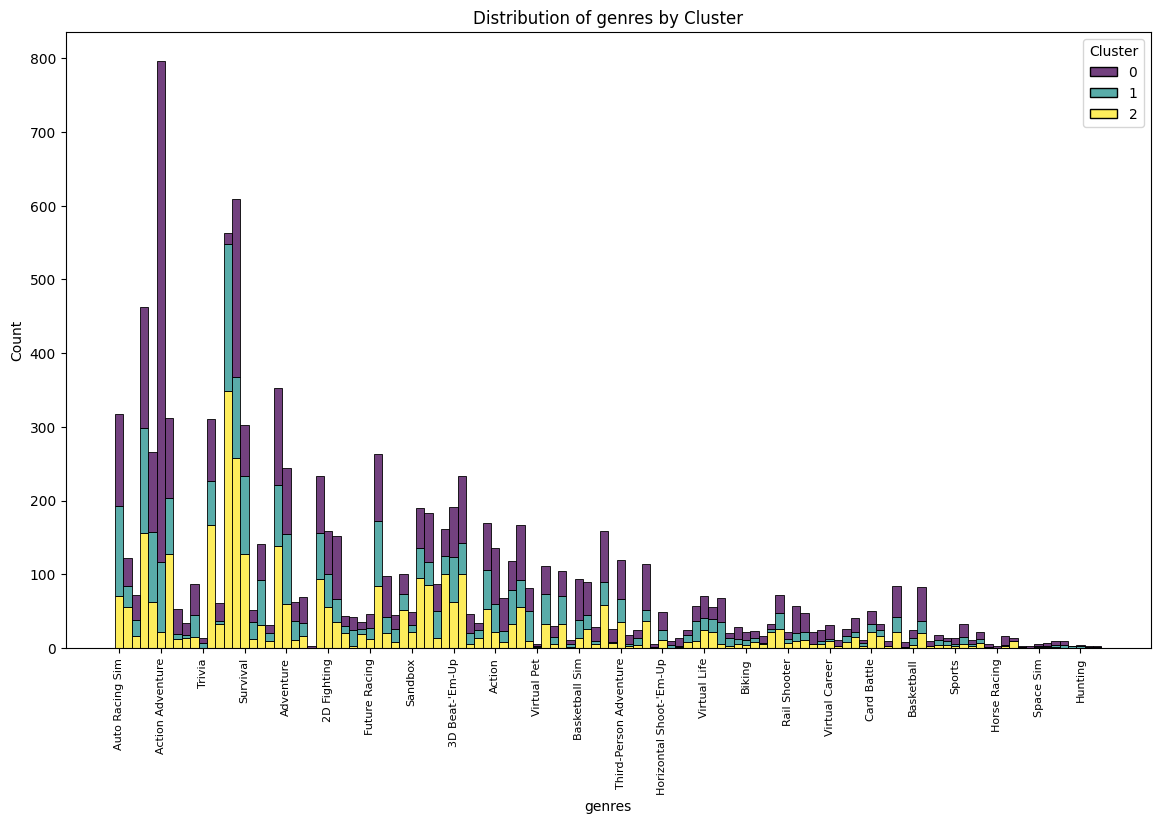

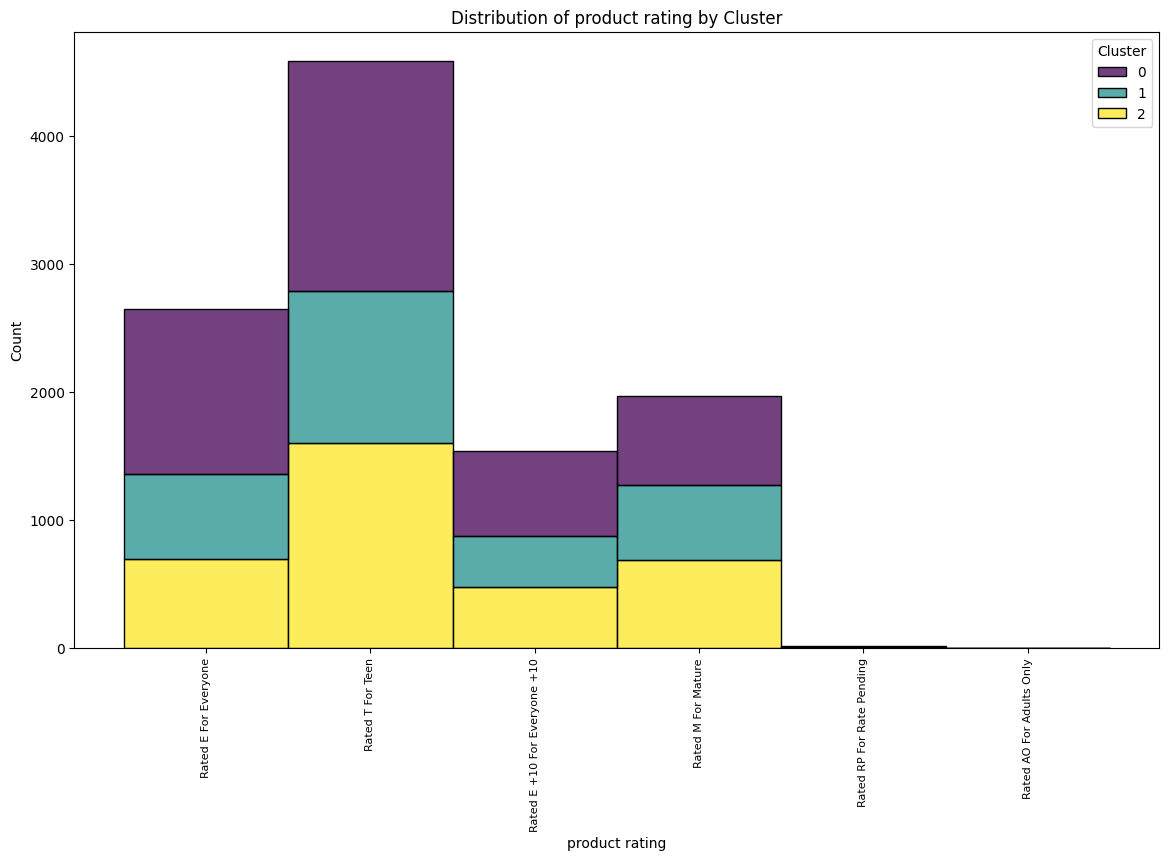

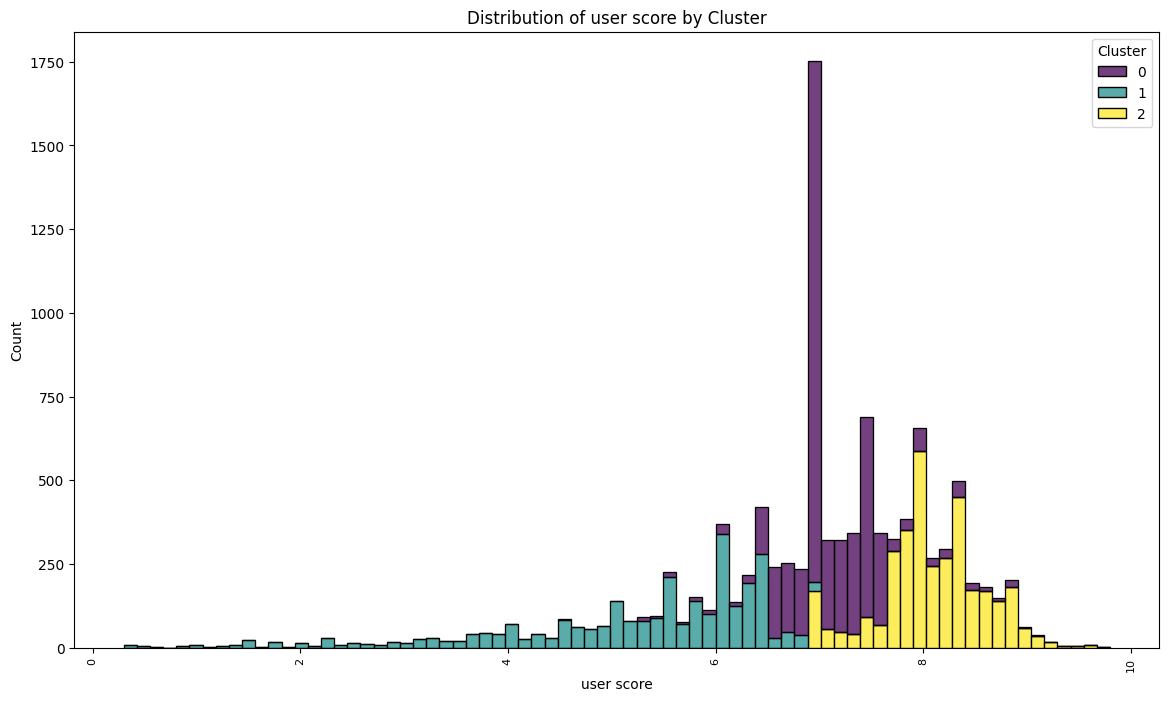

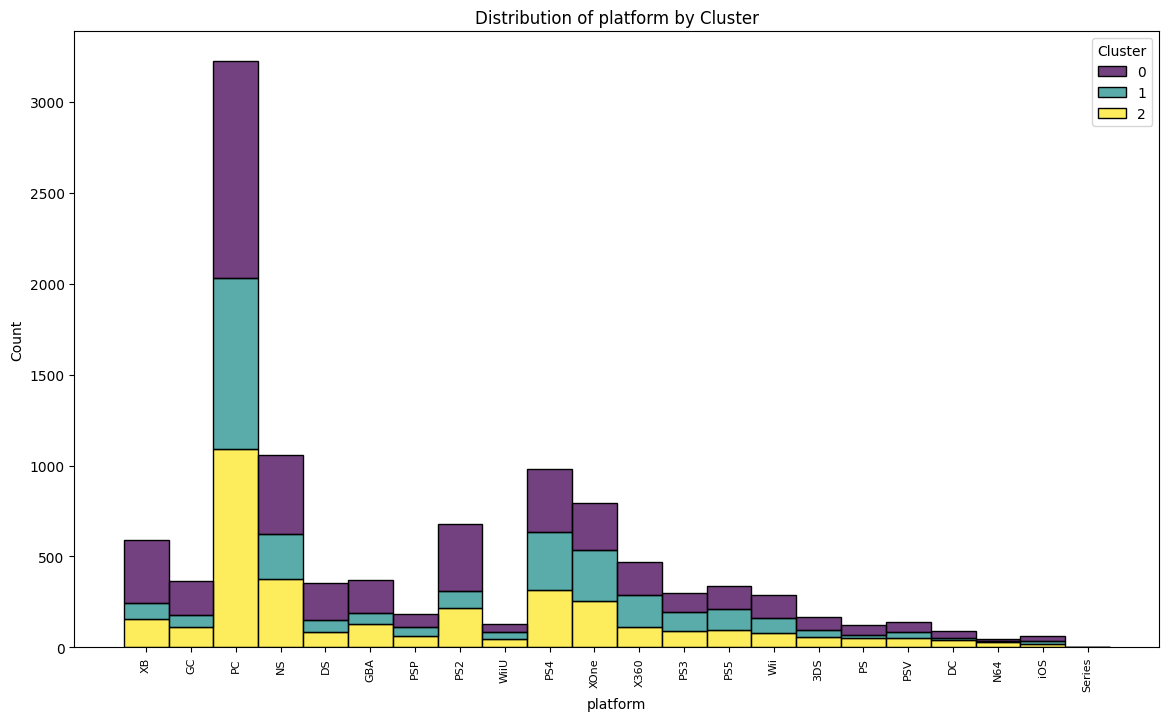

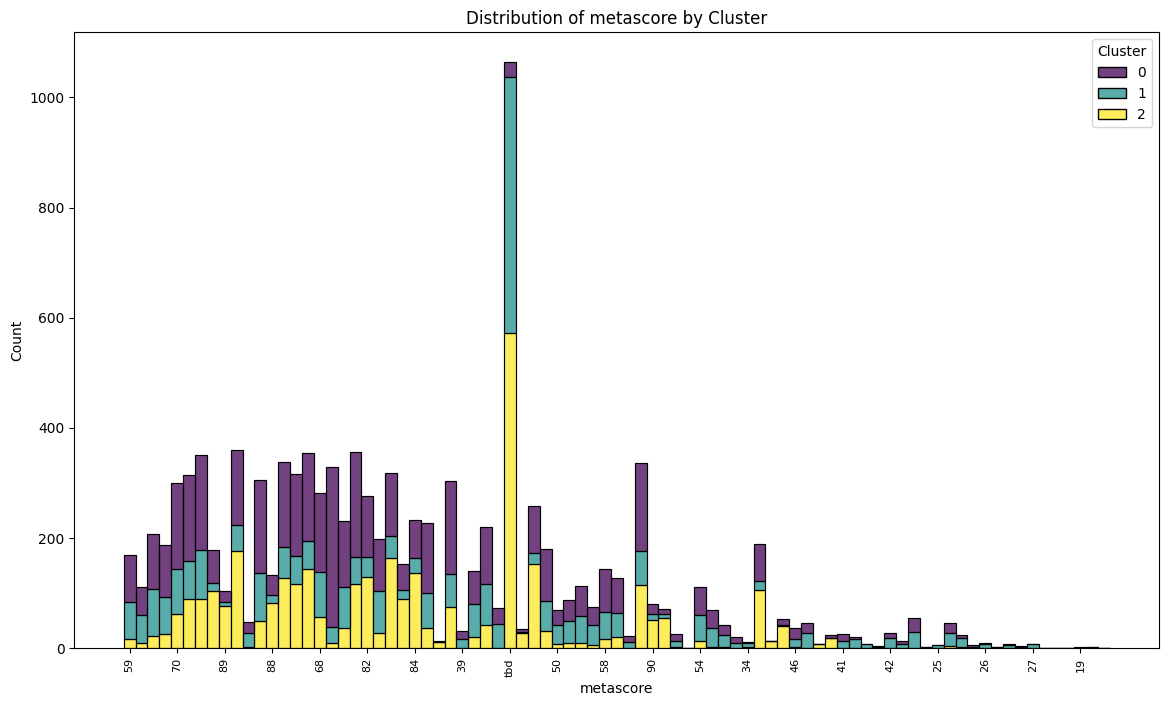

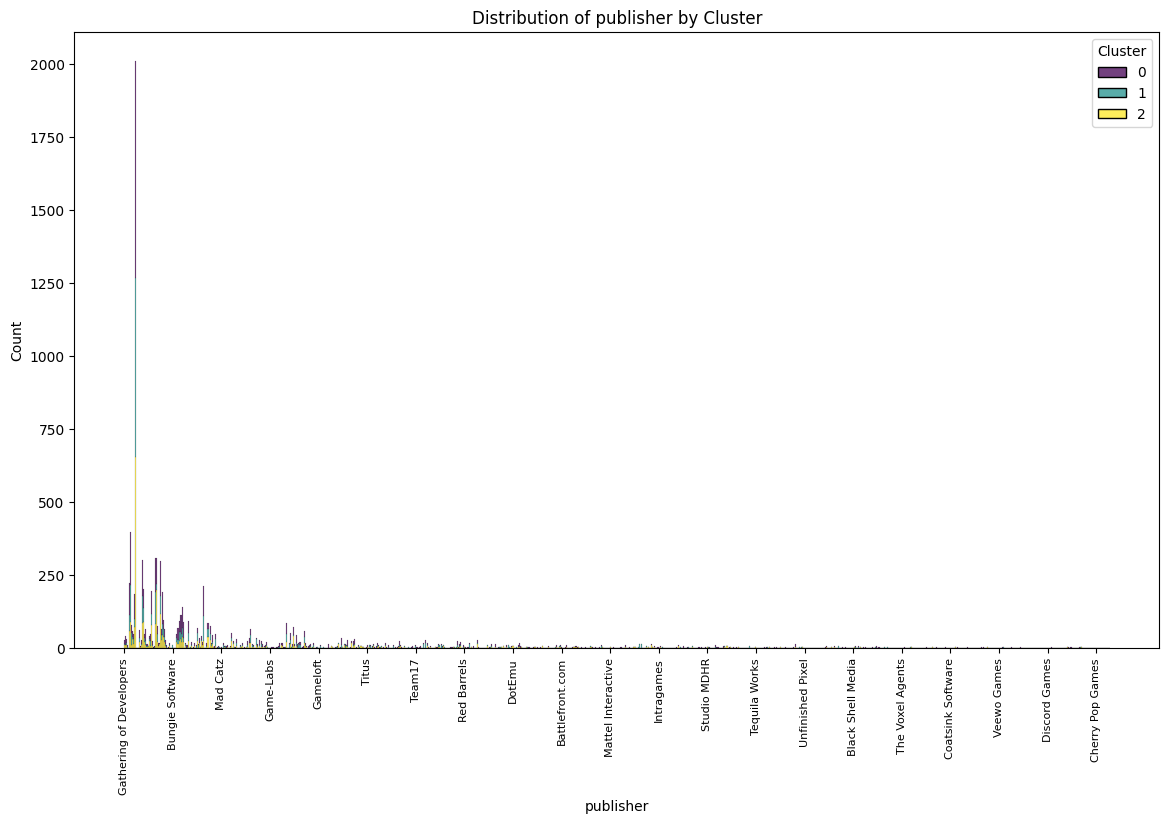

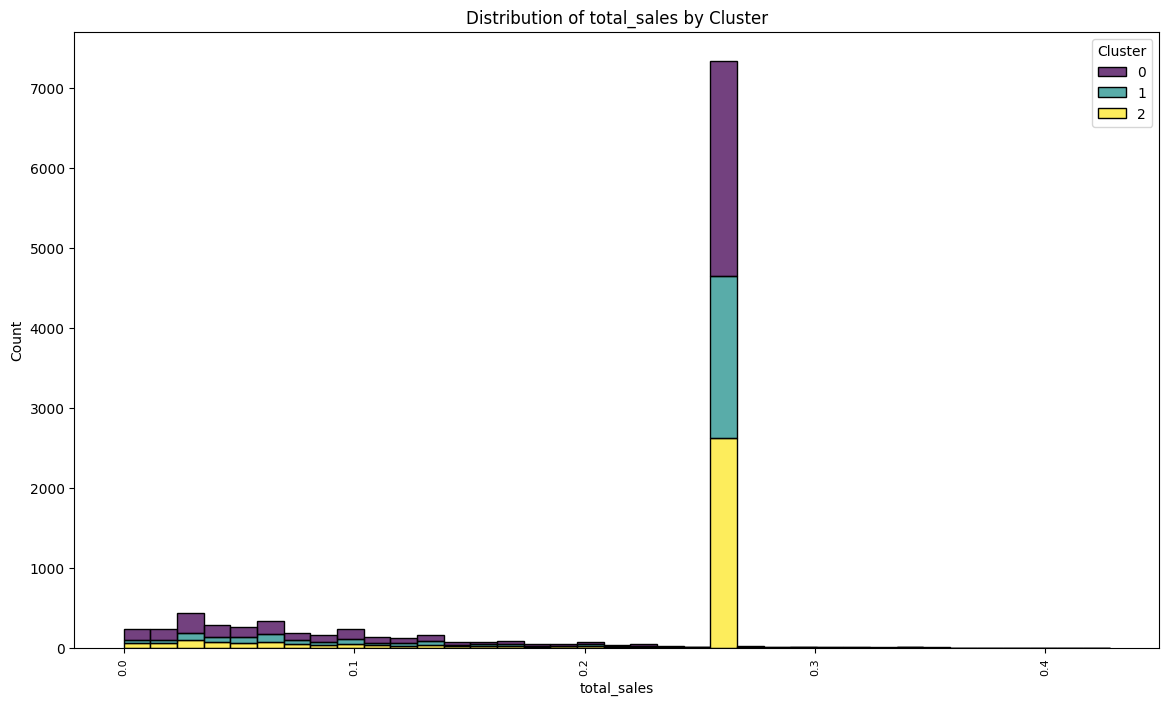

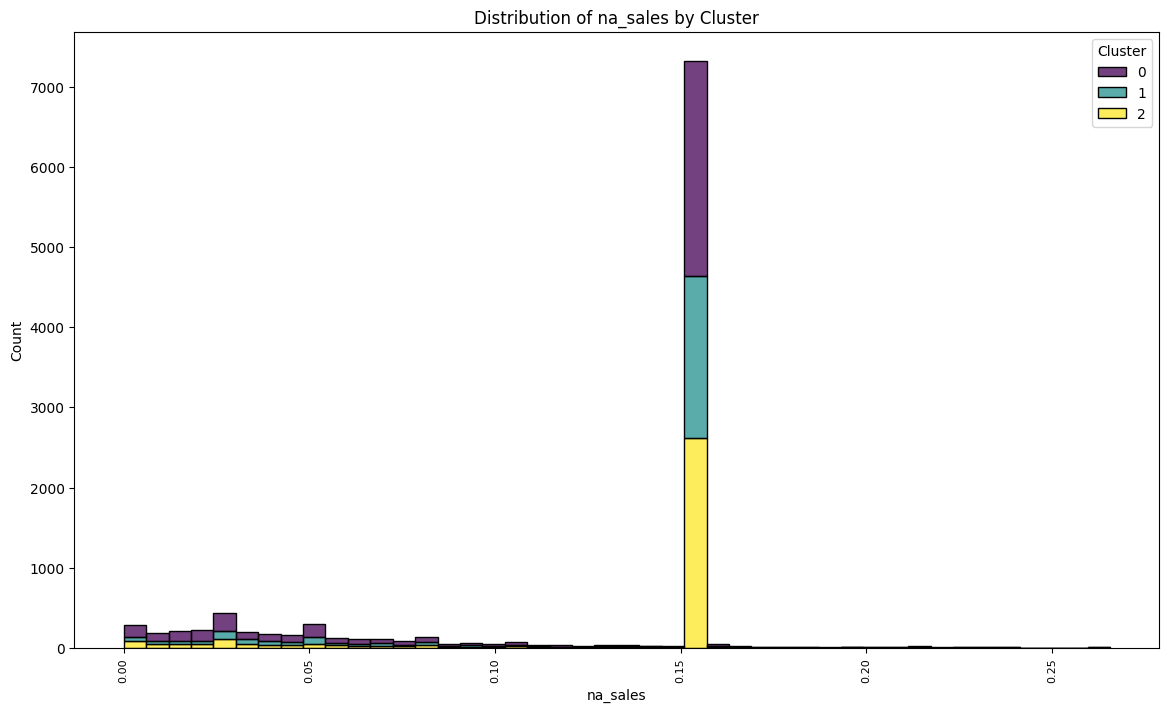

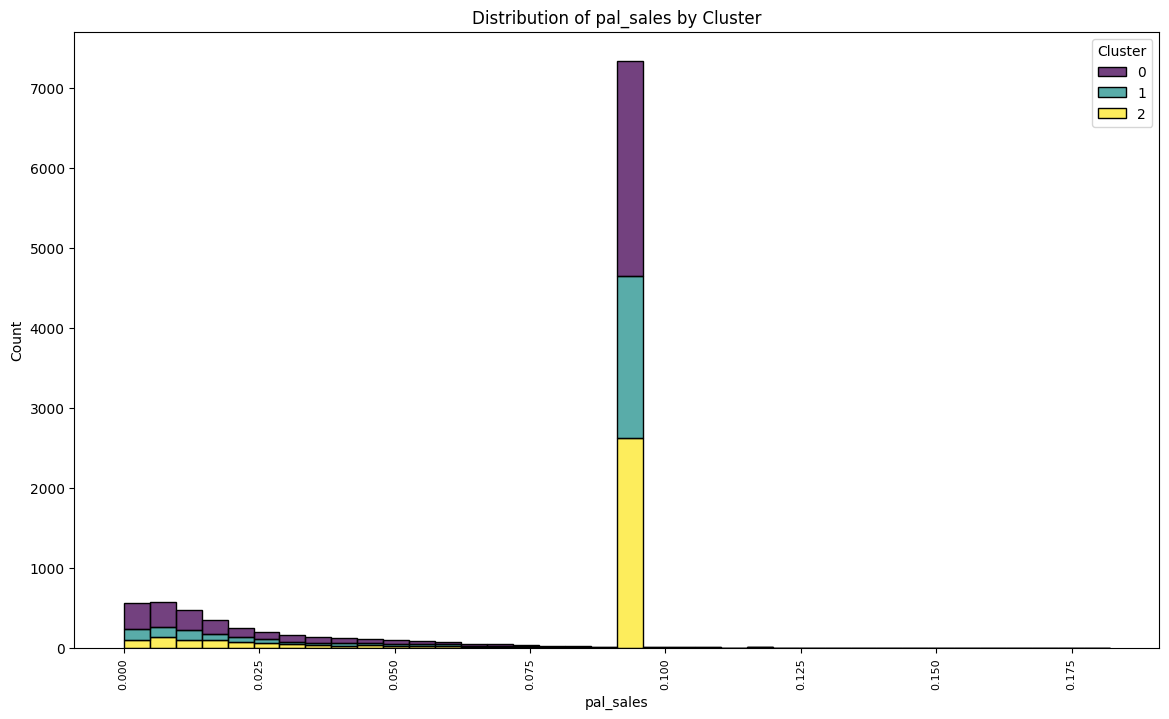

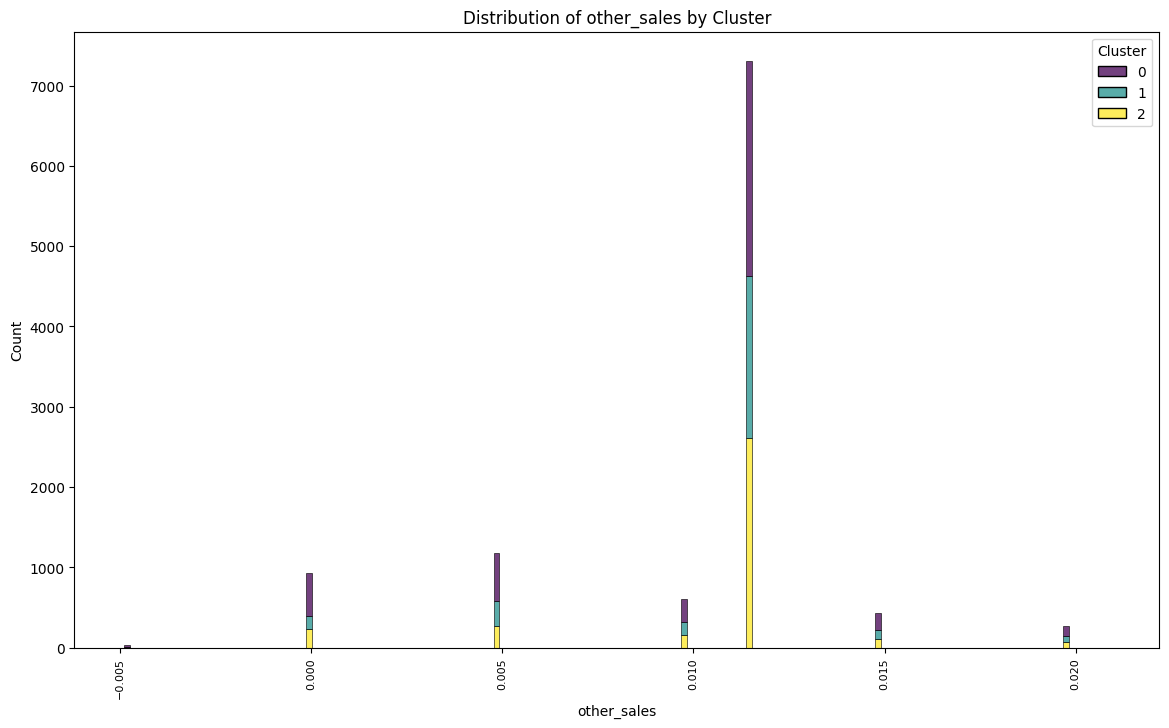

In [22]:
# Set a larger figure size for all plots
plt.rcParams['figure.figsize'] = [14, 8]

for column in data.columns:
    if column != 'Cluster':
        plt.figure()
        sns.histplot(data=data, x=column, hue='Cluster', multiple='stack', palette='viridis')
        plt.title(f'Distribution of {column} by Cluster')

        # Get current x-axis labels
        labels = plt.gca().get_xticklabels()

        # Threshold for maximum number of labels before reducing
        max_labels = 20

        if len(labels) > max_labels:
            # Determine the step size to display every nth label
            step = max(1, len(labels) // max_labels)  # Show at most max_labels

            # Apply rotation and limit the number of labels
            plt.xticks(ticks=range(0, len(labels), step), rotation=90, fontsize=8)
        else:
            plt.xticks(rotation=90, fontsize=8)

        plt.show()

### Feature-Feature plt

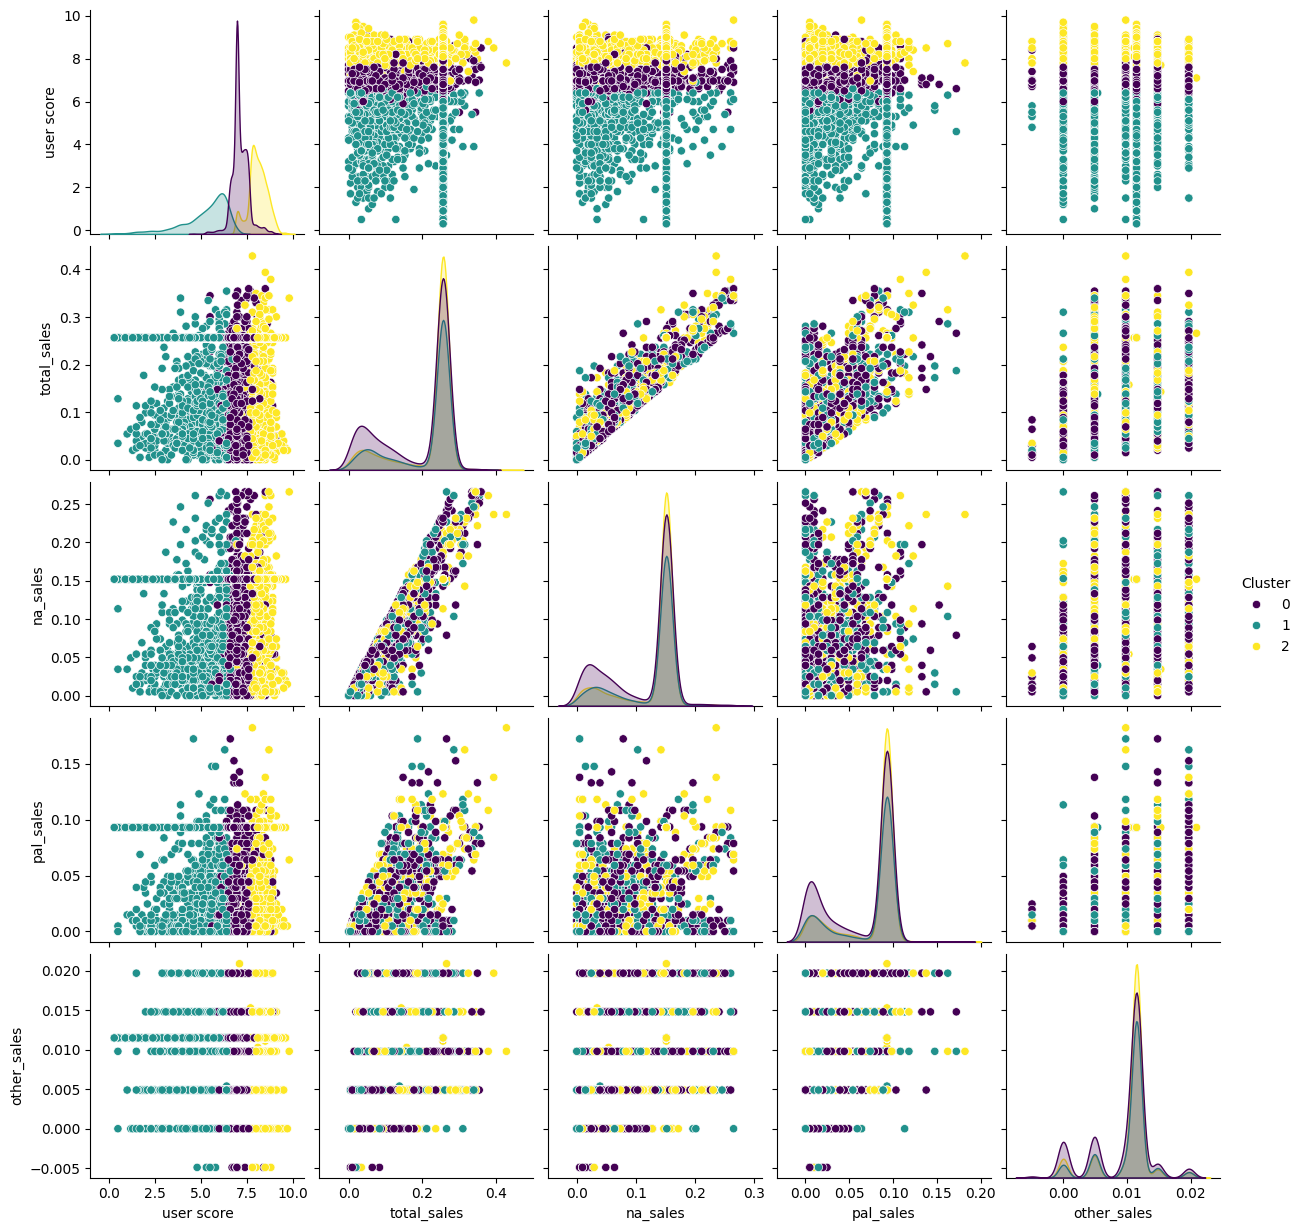

In [23]:
# Use pair plots to visualize relationships between features within each cluster
sns.pairplot(data, hue='Cluster', palette='viridis')
plt.show()


# Classification

## Load dataset

In [60]:
data = pd.read_csv(f'{project_path}/datasets/data_processed.csv')

## Drop unnecessary Cols

In [61]:
# ['title', 'genres', 'product rating', 'user score', 'user ratings count',
#        'platform', 'metascore', 'metascore_count', 'img', 'publisher',
#        'developer', 'total_sales', 'na_sales', 'pal_sales', 'other_sales',
#        'release date', 'last_update', 'total score', 'score',
#        'Processed_title', 'Stemmed_title', 'Lemmatized_title',
#        'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres']

data.drop(columns=['title',
       'img',

       'release date', 'last_update', 'score',
       'Processed_title', 'Stemmed_title', 'Lemmatized_title',
       'Processed_genres', 'Stemmed_genres', 'Lemmatized_genres'], inplace=True)

## Feature Selection

In [62]:
features = ['genres', 'product rating', 'platform', 'metascore', 'total_sales', 'user ratings count', 'metascore_count', 'publisher',
       'developer', 'na_sales', 'pal_sales', 'other_sales', 'total score', ]

## Target Selection

In [63]:
target = 'user score'

## Convert Continuous to Categorical

In [64]:
bins = [0, 4, 7, 10]  # Example bin ranges
labels = ['low', 'medium', 'high']

# Create a new categorical target column
data['user_score_category'] = pd.cut(data[target], bins=bins, labels=labels)

## Categorical & Numerical Separation

In [65]:
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()

numerical_columns.remove('user score')
categorical_columns.remove('user_score_category')
print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)


Numerical columns: ['user ratings count', 'metascore_count', 'total_sales', 'na_sales', 'pal_sales', 'other_sales', 'total score']
Categorical columns: ['genres', 'product rating', 'platform', 'metascore', 'publisher', 'developer']


In [39]:
# Split numerical and categorical columns
numerical_columns = ['total_sales']
categorical_columns = ['genres', 'product rating', 'platform', 'metascore']

## Separate Features and Labels

In [66]:
# Ensure only relevant columns are processed
X = data[features]
y = data['user_score_category']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Categorical & Numerical Preprocessors

In [67]:
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

## Train & Test models

### Radnom Forest

In [68]:
print("Model: Random Forest")
rf_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', RandomForestClassifier(random_state=42))])
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.2f}")
print("-" * 30)

Model: Random Forest
Accuracy: 0.78
Precision: 0.79
Recall: 0.78
F1 Score: 0.77
------------------------------


### Logistic Regression

In [69]:
print("Model: Logistic Regression")
lr_clf = Pipeline(steps=[('preprocessor', preprocessor),
                         ('classifier', LogisticRegression(random_state=42, max_iter=1000))])
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_lr, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.2f}")
print("-" * 30)

Model: Logistic Regression
Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F1 Score: 0.76
------------------------------


### SVM

In [70]:
print("Model: SVM")
svm_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', SVC(random_state=42))])
svm_clf.fit(X_train, y_train)
y_pred_svm = svm_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_svm, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_svm, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_svm, average='weighted'):.2f}")
print("-" * 30)

Model: SVM
Accuracy: 0.72
Precision: 0.73
Recall: 0.72
F1 Score: 0.71
------------------------------


### Decision Tree

In [71]:
print("Model: Decision Tree")
dt_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', DecisionTreeClassifier(random_state=42))])
dt_clf.fit(X_train, y_train)
y_pred_dt = dt_clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_dt, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_dt, average='weighted'):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred_dt, average='weighted'):.2f}")
print("-" * 30)

Model: Decision Tree
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
------------------------------
